# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [18]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$
\frac{\partial}{\partial w_i}L(w, w_0) = \frac{1}{N}\sum_i^N\frac{1}{1+\exp(-y_i(w^\top x_i+w_0))}\exp(-y_i(w^\top x_i+w_0))(-y_i x_i) + \gamma sign(w_i) + 2 \beta w_i
$$

$$
\frac{\partial}{\partial w_0}L(w, w_0) = \frac{1}{N}\sum_i^N\frac{1}{1+\exp(-y_i(w^\top x_i+w_0))}\exp(-y_i(w^\top x_i+w_0))(-y_i)
$$

##### Put your markdown formulas here below:

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [68]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """
    return np.mean(np.log(np.exp(-y * ((X @ np.transpose(w)) + w0)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w)

#### 3. [0.5 points] Implement the gradient (as a function)

In [69]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''
    tmp = np.exp(-y * ((X @ np.transpose(w)) + w0))
    grad_w0 = -np.mean(tmp / (1 + tmp) * y)
    grad_w = -1 / len(X) * np.dot(tmp / (1 + tmp ) * y, X) + gamma * np.sign(w) + 2 * beta * w
    return grad_w, grad_w0

#### Check yourself

In [70]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [71]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [72]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.threshold = 0
        self.loss_history = []
        
        
    def fit(self, X, y):
        
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        np.random.seed(self.random_state)

        self.w = np.ones(np.array(X)[0].size)
        self.w0 = 1
        
        for i in range(self.max_iter):

            w, w0 = get_grad(X, y, self.w, self.w0, gamma = self.gamma, beta = self.beta)
            w_new = self.w - self.learning_rate * w
            w0_new = self.w0 - self.learning_rate * w0
            
            self.loss_history.append(loss(X, y, self.w, self.w0, gamma = self.gamma, beta = self.beta))
           
            if(np.linalg.norm(w_new - self.w) <= self.tolerance):
                self.w = w_new
                self.w0 = w0_new
                break
            self.w = w_new
            self.w0 = w0_new
                      
        fpr, tpr, thresholds = roc_curve(y, self.predict_proba(X)[1,:])
        gm = np.sqrt((1 - fpr) * tpr)
        x = np.argmax(gm)
        self.threshold = thresholds[x]
    
    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        pred_prob = self.predict_proba(X)[1, :]  
        predict = np.where(pred_prob >= self.threshold, 1, -1)
        return predict

    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        return np.array([1 / (1 + np.exp((X @ self.w) + self.w0)), 1 / (1 + np.exp(-(X @ self.w) - self.w0))])
    
    def logistic_func(x):
        return 1 / (1 + np.exp(-x))

In [73]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [74]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

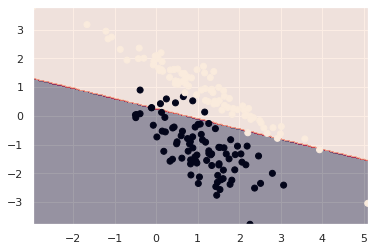

In [75]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

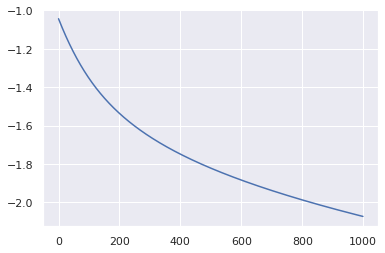

In [76]:
plt.plot(model.loss_history)

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [65]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
kernels = ['linear', 'poly', 'rbf', 'sigmoid']


acc = {'linear': [], 'poly': [], 'rbf': [], 'sigmoid': []}
roc_auc = {'linear': [], 'poly': [], 'rbf': [], 'sigmoid': []}
f1 = {'linear': [], 'poly': [], 'rbf': [], 'sigmoid': []}


regularization = np.linspace(0.001, 5, 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

for kernel in kernels:
    for c in regularization:
        clf =  SVC(kernel=kernel, C=c)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        acc[kernel].append(accuracy_score(y_test,y_pred_test))
        roc_auc[kernel].append(roc_auc_score(y_test,y_pred_test))
        f1[kernel].append(f1_score(y_test,y_pred_test))

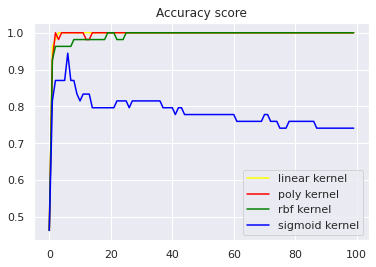

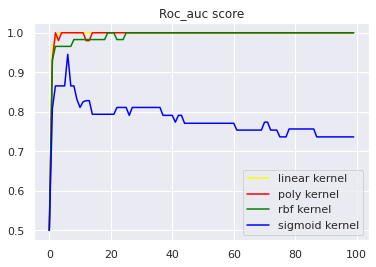

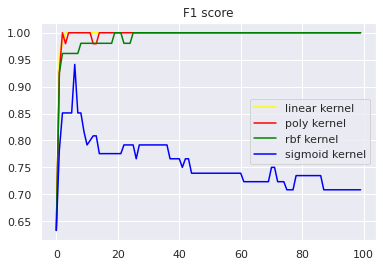

In [66]:
plt.plot(acc['linear'], label = 'linear kernel', color = 'yellow')
plt.plot(acc['poly'], label = 'poly kernel', color = 'red')
plt.plot(acc['rbf'], label = 'rbf kernel', color = 'green')
plt.plot(acc['sigmoid'], label = 'sigmoid kernel', color = 'blue')
plt.title("Accuracy score")
plt.legend()
plt.show()

plt.plot(roc_auc['linear'], label='linear kernel', color = 'yellow')
plt.plot(roc_auc['poly'], label='poly kernel', color = 'red')
plt.plot(roc_auc['rbf'], label='rbf kernel', color = 'green')
plt.plot(roc_auc['sigmoid'], label='sigmoid kernel', color = 'blue')
plt.title("Roc_auc score")
plt.legend()
plt.show()

plt.plot(f1['linear'], label='linear kernel', color = 'yellow')
plt.plot(f1['poly'], label='poly kernel', color = 'red')
plt.plot(f1['rbf'], label='rbf kernel', color = 'green')
plt.plot(f1['sigmoid'], label='sigmoid kernel', color = 'blue')
plt.title("F1 score")
plt.legend()
plt.show()


Видно, что accuracy score наилучшая при rbd kernel и наихудшая при sigmoid kernel
<br>
Аналогичная ситуация и для двух других метрик: roc auc score и f1 score: хорошее и +- одинаковое качество для linear, poly, rbf kernel, худшее для sigmoid kernel
<br>
Также видно, что с увеличением коэффициента регуляризации качество для всех 3 метрик для sigmoid kernel снижается, оптимальный коэффициент - в районе 10 
<br>
При этом для rbf kernel ситуация противоположная: с увеличением пенальти монотонно возрастает и качество

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [2]:
! pip install pymorphy2
from tqdm import tqdm_notebook
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
import json
warnings.filterwarnings("ignore") 

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 8.2 MB 10.4 MB/s 


In [3]:
!pip install kaggle

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [7]:
!kaggle datasets download -d d0rj3228/russian-literature/prose

 44% 9.00M/20.5M [00:00<00:00, 39.9MB/s]
100% 20.5M/20.5M [00:00<00:00, 68.6MB/s]


In [8]:
!unzip russian-literature.zip

Archive:  russian-literature.zip
  inflating: README.md               
  inflating: Tolstoy_and_Chekhov_1901.jpg  
  inflating: poems/Blok/info.csv     
  inflating: poems/Blok/╨Т╨╛╨╖╨╝╨╡╨╖╨┤╨╕╨╡.txt  
  inflating: poems/Blok/╨Ф╨▓╨╡╨╜╨░╨┤╤Ж╨░╤В╤М.txt  
  inflating: poems/Blok/╨Ъ╨╛╤А╤А╨╡╤Б╨┐╨╛╨╜╨┤╨╡╨╜╤Ж╨╕╤П ╨С╨░╨╗╤М╨╝╨╛╨╜╤В╨░ ╨╕╨╖ ╨Ь╨╡╨║╤Б╨╕╨║╨╕.txt  
  inflating: poems/Blok/╨б╨║╨╕╤Д╤Л.txt  
  inflating: poems/Blok/╨б╨╛╨╗╨╛╨▓╤М╨╕╨╜╤Л╨╣ ╤Б╨░╨┤.txt  
error:  cannot create poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
  inflating: poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П. ╨Ъ╨╜╨╕╨│╨░ ╨▓╤В╨╛╤А╨░╤П (1904-1908).txt  
  inflating: poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П. ╨Ъ╨╜╨╕╨│╨░ ╨┐╨╡╤А╨▓╨░╤П (1898-1904).txt  
  inflating: poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П. ╨Ъ╨╜╨╕╨│╨░ ╤В╤А╨╡╤В╤М╤П (1907-1916).txt  
  inflating: poems/Blok/╨и╤Г╤В╨╛╤З╨╜╤Л╨╡ ╤Б╤В╨╕╤Е╨╕ ╨╕ ╤Б╤Ж╨╡╨╜╨║╨╕.txt  
  inflating: poems/Lermont

In [13]:
import glob
import nltk
import random
from nltk import tokenize
import string
from string import digits
import pymorphy2
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [87]:
sen_author = {"Blok": [], "Chekhov": [], "Dostoevsky": [], "Gogol": [], "Lermontov": [], "Pushkin": [] }

for author in sen_author:
  for path in glob.glob('prose/' + author + '/*.txt'):
    with open(path, 'r', encoding='utf8') as prose: 
      book = prose.read()
      book_splitted = tokenize.sent_tokenize(book, language='russian')
      for sentence in book_splitted: 
          sentence.replace('\n', ".")
          if len(sentence) >= 15:
            sen_author[author].append(sentence)

In [88]:
np.random.seed(15)
sen_author["Blok"] = np.random.choice(sen_author["Blok"], 15000)
sen_author["Chekhov"] = np.random.choice(sen_author["Chekhov"], 7000)
sen_author["Dostoevsky"] = np.random.choice(sen_author["Dostoevsky"], 20000)
sen_author["Gogol"] = np.random.choice(sen_author["Gogol"], 40000)
sen_author["Lermontov"] = np.random.choice(sen_author["Lermontov"], 3000)
sen_author["Pushkin"] = np.random.choice(sen_author["Pushkin"], 30000)

data = []
for author in sen_author:
    for sen in sen_author[author]:
      data.append([sen, author])

In [89]:
data_frame = pd.DataFrame(data, columns=["sentence","author"])
data_frame.head(10)

,sentence,author
0,"Тут я, однако, усумнился про себя.",Blok
1,Едкий городской дым кутает меня в грязную шубу.,Blok
2,С трудом пробираясь во мраке и бездарности рос...,Blok
3,Снег почти сошел; только под старыми елями сер...,Blok
4,"Один выехал вперед, конь крепко уперся ногами ...",Blok
5,"Ошеломлены глаза, тошно от найденной уже, не и...",Blok
6,"Все так и прет прямо в глаза, лубочное, аляпов...",Blok
7,Он был человеком.,Blok
8,Он прислушивался с легким удивлением и очень д...,Blok
9,Дырявые и мертвые ее глаза смотрят все еще нежно.,Blok


In [33]:
# get russian stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

word_tokenizer = nltk.WordPunctTokenizer()
def process_data(data):

    for _, item in data.iterrows():
        
        text_lower = item['sentence'].lower() # convert words in a text to lower case
        tokens     = word_tokenizer.tokenize(text_lower) # splits the text into tokens (words)
        
        # remove punct and stop words from tokens
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and not word.isnumeric())]
        
        item['sentence'] = tokens 
    
    return data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
process_data(data_frame)
data_frame.head()

,sentence,author
0,"[одна, прядь, волос, упала, низко, небрежно, з...",Blok
1,"[это, какие, тихие, болотные, светловзоры, "".]",Blok
2,"[старинные, седые, бакены, синяя, рубашка, пол...",Blok
3,"[хочется, сказать, этих, северных, светловзора...",Blok
4,"[покраснеет, опустит, шелковые, ресницы, приме...",Blok


In [44]:
import pymorphy2 # Морфологический анализатор

# define lemmatizer
morph = pymorphy2.MorphAnalyzer()
for ind in tqdm(range(len(data_frame))):
    aword_norm = [morph.parse(word)[0].normal_form for word in data_frame['sentence'][ind]]
    data_frame['sentence'][ind] = ' '.join(aword_norm)
data_frame.head()

  0%|          | 0/115000 [00:00<?, ?it/s]

,sentence,author
0,один прядь волос упасть низко небрежно зашнуро...,Blok
1,"это какой тихий болотный светловзор "".",Blok
2,старинный седой бакен синий рубашка полоска ст...,Blok
3,хотеться сказать этот северный светловзор сооб...,Blok
4,покраснеть опустить шёлковый ресница принять д...,Blok


In [50]:
vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(data_frame['sentence'])
# Apply Bag-Of-Words to text
X = vectorizer.transform(data_frame['sentence'])
data_bag_of_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_bag_of_words['author'] = data_frame['author']
data_bag_of_words.head(10)

,бог,ваш,весь,взять,видеть,время,всякий,глаз,говорить,год,голова,дело,день,дом,друг,другой,думать,душа,жизнь,знать,иванович,казаться,какой,который,лицо,место,мой,мочь,наш,несколько,один,отвечать,очень,первый,пугачёв,рука,сам,самый,свой,сердце,сказать,слово,стать,сторона,такой,тот,ты,хотеть,человек,это,author
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blok
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Blok
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blok
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,Blok
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blok
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Blok
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blok
7,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blok
8,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Blok
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blok


In [51]:
vectorizer = TfidfVectorizer(max_features = 50)
vectorizer.fit(data_frame['sentence'])
X = vectorizer.transform(data_frame['sentence'])
data_tfid = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
data_tfid['author'] = data_frame['author']
data_tfid.head(10)

,бог,ваш,весь,взять,видеть,время,всякий,глаз,говорить,год,голова,дело,день,дом,друг,другой,думать,душа,жизнь,знать,иванович,казаться,какой,который,лицо,место,мой,мочь,наш,несколько,один,отвечать,очень,первый,пугачёв,рука,сам,самый,свой,сердце,сказать,слово,стать,сторона,такой,тот,ты,хотеть,человек,это,author
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769771,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.63832,Blok
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.61368,0.789555,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.752995,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.658027,0.000000,0.0,0.0,0.0,0.00000,Blok
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.564469,0.0,0.000000,0.0,0.0,0.658571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.497654,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.820161,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.415062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.393776,0.0,0.0,0.0,0.00000,Blok
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,Blok


Видно, что таблицы в целом похожи, но есть отличия: count_vectorizer работает с целыми числами (так как встречаемость слов - целое число), в то время как tf-idf работает с числами типа float (так как считает сколько раз встретилось слово в тексте * обратная частота встречаемости слова в наборе текстов) 
<br>
Можно увидеть, что tf-idf лучше работает, так как учитывает не только частоту встречаемости слова, но также его значимость


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [ ]:
# your code here

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [ ]:
# your code here